
# ResNet-Competition

__Author:
Viktor Karlsson [viktor2karlsson@gmail.com](mailto:viktor2karlsson@gmail.com)__

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

from keras.models import Model, Sequential
from keras.datasets import mnist
from keras.layers import add as keras_add
from keras.layers import Dense, Input, Activation
from keras.initializers import RandomNormal
from keras.regularizers import l1, l2
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

# load (downloaded if needed) the MNIST dataset
(X_train_all, Y_train_all), (X_test, Y_test) = mnist.load_data()

Using TensorFlow backend.


## Data splitting and preprocessing

In [2]:
print(f'Shape of X_train is: {X_train_all.shape}')
print(f'Shape of Y_train is: {Y_train_all.shape}\n')

print('Reshaping training data into vector...')
X_train_all = X_train_all.reshape(X_train_all.shape[0], np.prod(X_train_all.shape[1:]))
print(f'Shape of X_train is now: {X_train_all.shape}\n')

print('Transforming training labels into one-hot encodings...')
Y_train_all = to_categorical(Y_train_all)
print(f'Shape of Y_train is now: {Y_train_all.shape}\n')

X_train, X_val, Y_train, Y_val = train_test_split(X_train_all, Y_train_all, test_size=5000)
print(f'Using {len(X_train)} for training and {len(X_val)} for validation.')
print(f'Using {len(X_test)} for testing')


Shape of X_train is: (60000, 28, 28)
Shape of Y_train is: (60000,)

Reshaping training data into vector...
Shape of X_train is now: (60000, 784)

Transforming training labels into one-hot encodings...
Shape of Y_train is now: (60000, 10)

Using 55000 for training and 5000 for validation.
Using 10000 for testing


# MLP
Defining functions that will be used for training MLP's

In [3]:
ES = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

def custom_dense_mlp(dim, is_input_layer=False, input_dim=784, activation='relu', seed=1337):
    
    '''Function for creating a common layers in the MLP used in this notetbook'''
    
    if is_input_layer:    
        return Dense(dim, 
                     input_dim=input_dim, 
                     activation=activation, 
                     kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=seed), 
                     bias_initializer='zeros', 
                     kernel_regularizer=l2(0.01)
                    )
    else:
        return Dense(dim,  
                     activation=activation, 
                     kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=seed), 
                     bias_initializer='zeros', 
                     kernel_regularizer=l2(0.01)
                    )        
#end def

def create_mlp(dims, activation='relu', input_dim=784, output_dim=10):
    
    '''
    Function for stacking together multiple common_layers into a list 
    which can later be used in a keras Sequential model.
    '''
    
    layers = list()
    
    #input layer
    layers.append(custom_dense_mlp(dims[0], is_input_layer=True))
    
    dims = dims[1:]
    
    #hidden layers
    for dim in dims:
        layers.append(custom_dense_mlp(dim))
    #end for
    
    #output layer
    layers.append(custom_dense_mlp(output_dim, activation='softmax'))
    model = Sequential(layers)
    return model

#end def

def train_mlp(model, X_train, Y_train):
    
    ES = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    model.summary()
    history = model.fit(X_train, Y_train, epochs=200, callbacks=[ES], batch_size=256, validation_data=(X_val, Y_val), verbose=0)

    return history

def history_plot(history, X_val, Y_val):
    
    '''
    Function for plotting validation and training accuracy and loss. 
    '''
    
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    val_acc = history.model.evaluate(X_val, Y_val)[1]
    plt.title('model accuracy - {}'.format(round(val_acc, 5)))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    return
#end def 


## Training MLP's
To create a good environment for testing the power of the ResNet architecture I will create two different model architectures for which I can compare the results

### Shallow MLP
This first model is a MLP with 5 layers, using almost all of the avaliable 10.000 paramters.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_436 (Dense)            (None, 12)                9420      
_________________________________________________________________
dense_437 (Dense)            (None, 12)                156       
_________________________________________________________________
dense_438 (Dense)            (None, 12)                156       
_________________________________________________________________
dense_439 (Dense)            (None, 11)                143       
_________________________________________________________________
dense_440 (Dense)            (None, 10)                120       
Total params: 9,995
Trainable params: 9,995
Non-trainable params: 0
_________________________________________________________________
5000/5000 [==============================] - 0s 55us/step


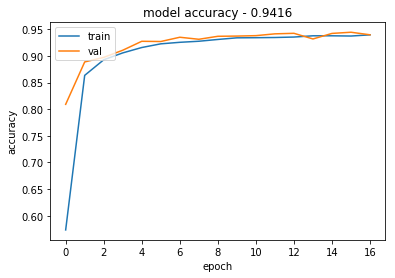

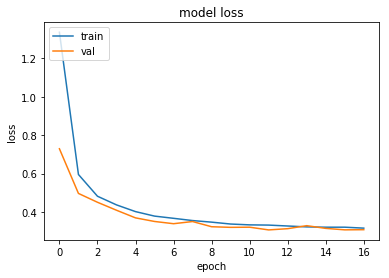

In [47]:
dims = [12,12,12,11]
shallow_model = create_mlp(dims)
shallow_history = train_mlp(shallow_model, X_train, Y_train)
history_plot(shallow_history, X_val, Y_val)

### Deep MLP
Since the purpose of ResNet is to enable efficient learning of deep models I see it appropriate to create a "very" deep MLP. Here a 13 layer model is created and tested.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_441 (Dense)            (None, 11)                8635      
_________________________________________________________________
dense_442 (Dense)            (None, 11)                132       
_________________________________________________________________
dense_443 (Dense)            (None, 11)                132       
_________________________________________________________________
dense_444 (Dense)            (None, 10)                120       
_________________________________________________________________
dense_445 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_446 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_447 (Dense)            (None, 10)                110       
__________

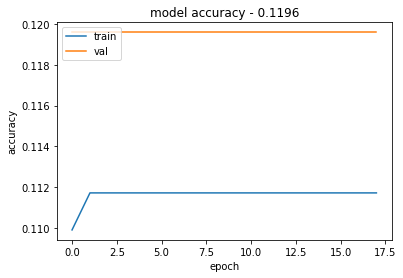

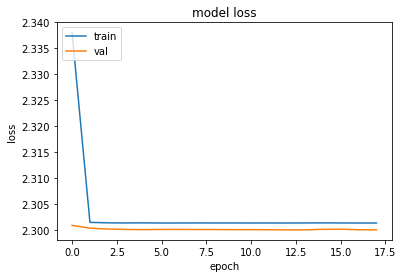

In [48]:
dims = [11]*3+[10]*8
deep_model = create_mlp(dims)
deep_history = train_mlp(deep_model, X_train, Y_train)
history_plot(deep_history, X_val, Y_val)

What we find is that this network performs worse that the shallower one described above. This might be to the initial reduction to 11 dimensions, or because of its depth. 

### Suuper deep MLP

To use the parameters more effectivly, we can try to first have a non-trainable layer to reduce the input dimension. 

In [ ]:
dims = [392] + [16]*6 + [12]*9 + [10]*7
super_deep_model = create_mlp(dims)
super_deep_model.layers[0].trainable = False
super_deep_history = train_mlp(super_deep_model, X_train, Y_train)
history_plot(super_deep_history, X_val, Y_val)

We find that the deep networks cannot be trained in the regular MLP configuration. 

### Slow step down MLP

In [ ]:
dims = [100, 50, 25, 15, 12, 10]
step_down_model = create_mlp(dims)
#step_down_model.layers[0] = Dense(120,trainable=False, activation=None, use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=1, seed=1337))
step_down_history = train_mlp(step_down_model, X_train, Y_train)
history_plot(step_down_history, X_val, Y_val)

# ResNet
We now turn to ResNets. This network focuses on learning the residuals in each step through letting the input to a layer bypass the activation. The number of layers that is bypassed can vary, as long as the dimension of input and output for this stack of layers are equivalent. 

In [8]:
def custom_dense_resnet(output_dim, x, activation='relu',trainable=True):
    '''Creates a keras dense layer for use in my ResNet architecture'''
    return Dense(output_dim,
                 activation=activation,
                 kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=1337),
                 trainable = trainable
                 )(x)
#end def

def resnet_block(dim, x):
    x = custom_dense_resnet(dim, x)
    shortcut = x
    x = custom_dense_resnet(dim, x)
    x = custom_dense_resnet(dim, x, activation=None)
    x = keras_add([shortcut, x])
    x = Activation('relu')(x)
    return x
#end def

def build_shallow_resnet():
    inp = Input(shape=(784,))
    x = custom_dense_resnet(12, inp)
    x = resnet_block(12, inp)
    x = custom_dense_resnet(11, x)
    x = custom_dense_resnet(10, x, activation='softmax')

    model = Model(input=[inp], output=x)
    return model
#end def

def build_deep_resnet():
    inp = Input(shape=(784,))
    x = custom_dense_resnet(11,inp)
    x = resnet_block(11, x)
    
    x = resnet_block(10, x)
    x = resnet_block(10, x)
    x = resnet_block(10, x)
    
    x = custom_dense_resnet(10, x, activation='softmax')

    model = Model(input=[inp], output=x)
    return model
#end def

def build_super_deep_resnet():
    inp = Input(shape=(784,))
    x = Dense(392, activation=None, kernel_initializer=RandomNormal(mean=0.0, stddev=1, seed=1337), use_bias=False, trainable = False)(inp)
    
    x = resnet_block(16, x)
    x = resnet_block(16, x)
    
    x = resnet_block(12, x)
    x = resnet_block(12, x)
    x = resnet_block(12, x)
    
    x = resnet_block(10, x)
    x = resnet_block(10, x)
    x = custom_dense_resnet(10, x)
    
    x = custom_dense_resnet(10, x, activation='softmax')

    model = Model(input=[inp], output=x)
    return model
#end def


/Users/Viktor/git/envs/fml-env/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_36 (Dense)                (None, 12)           9420        input_4[0][0]                    
__________________________________________________________________________________________________
dense_37 (Dense)                (None, 12)           156         dense_36[0][0]                   
__________________________________________________________________________________________________
dense_38 (Dense)                (None, 12)           156         dense_37[0][0]                   
__________________________________________________________________________________________________
add_10 (Ad

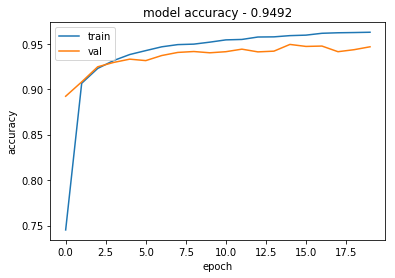

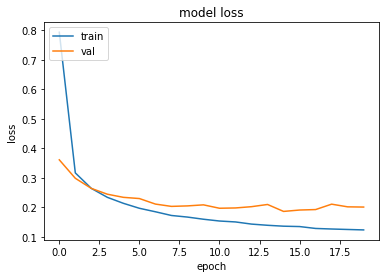

In [9]:
shallow_resnet_model = build_shallow_resnet()
shallow_resnet_history = train_mlp(shallow_resnet_model, X_train, Y_train)
history_plot(shallow_resnet_history, X_val, Y_val)

/Users/Viktor/git/envs/fml-env/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_41 (Dense)                (None, 11)           8635        input_5[0][0]                    
__________________________________________________________________________________________________
dense_42 (Dense)                (None, 11)           132         dense_41[0][0]                   
__________________________________________________________________________________________________
dense_43 (Dense)                (None, 11)           132         dense_42[0][0]                   
__________________________________________________________________________________________________
dense_44 (

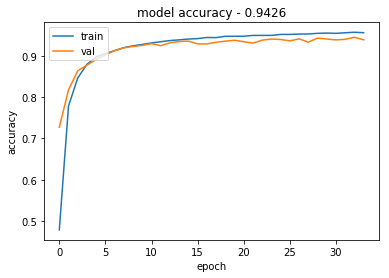

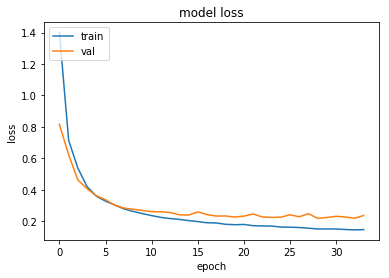

In [10]:
deep_resnet_model = build_deep_resnet()
deep_resnet_history = train_mlp(deep_resnet_model, X_train, Y_train)
history_plot(deep_resnet_history, X_val, Y_val)

/Users/Viktor/git/envs/fml-env/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_55 (Dense)                (None, 392)          307328      input_6[0][0]                    
__________________________________________________________________________________________________
dense_56 (Dense)                (None, 16)           6288        dense_55[0][0]                   
__________________________________________________________________________________________________
dense_57 (Dense)                (None, 16)           272         dense_56[0][0]                   
__________________________________________________________________________________________________
dense_58 (

5000/5000 [==============================] - 0s 29us/step


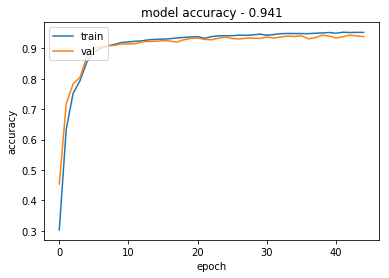

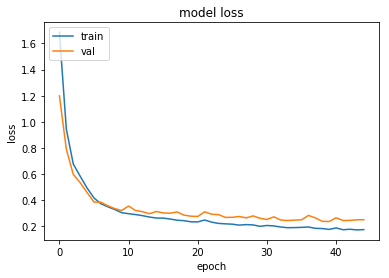

In [11]:
super_deep_resnet_model = build_super_deep_resnet()
super_deep_resnet_history = train_mlp(super_deep_resnet_model, X_train, Y_train)
history_plot(super_deep_resnet_history, X_val, Y_val)

In [ ]:
#model = KerasClassifier(build_fn=build_deep_resnet, verbose=0)
#param_grid = dict(epochs=[10,20])
#grid = GridSearchCV(estimator=model, param_grid=param_grid)
#history = grid.fit(X_train, Y_train, validation_data)